In [5]:
import sys
import numpy as np
import pandas as pd
import datetime
from numpy import cumsum, log, polyfit, sqrt, std, subtract
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
from arch import arch_model
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf

In [6]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4

## Data Loader

In [7]:
stocks_screener = pd.read_csv('nasdaq_screener_1637381777158.csv')
stocks_screener = stocks_screener[stocks_screener['Market Cap'].notna()]

In [8]:
M = 10**6
B = 10**9

bins =  np.array([0,50*M,300*M,2*B,10*B,200*B,np.inf])
ind = np.digitize(stocks_screener['Market Cap'], bins)

stocks_screener['Cap Group'] = ind

gb = stocks_screener.groupby('Cap Group')
list_of_groupbed_stocks = [gb.get_group(x) for x in gb.groups]

cap_list = ['nano','micro','small','medium','large','mega']
stock_cap_dict = dict()
for i in range(len(cap_list)):
    stock_cap_dict[cap_list[i]] = list_of_groupbed_stocks[i]['Symbol']

In [34]:
(stock_cap_dict['mega']).sample(n=10)

453      AMZN
1860      CRM
5324     NTES
2142      DHR
7862       VZ
4464      LLY
1666    CMCSA
47        ABT
1990      CVX
3325    GOOGL
Name: Symbol, dtype: object

In [35]:
df = yf.download("GOOGL", start="2010-01-01", end="2021-04-30")
#yf.Ticker('LYB')
#df = ticker.history(period="max")
#df['Close'].plot(title="MRNA's stock price")

[*********************100%***********************]  1 of 1 completed


In [36]:
df['Return'] = df['Close'].pct_change().mul(100)
df = df.dropna()
df

,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
2010-01-05,313.903900,314.234222,311.081085,312.307312,312.307312,6003391,-0.440366
2010-01-06,313.243256,313.243256,303.483490,304.434448,304.434448,7949443,-2.520871
2010-01-07,305.005005,305.305298,296.621613,297.347351,297.347351,12815771,-2.327955
2010-01-08,296.296295,301.926941,294.849854,301.311310,301.311310,9439151,1.333107
2010-01-11,302.532532,302.532532,297.317322,300.855865,300.855865,14411374,-0.151154
...,...,...,...,...,...,...,...
2021-04-23,2267.000000,2306.120117,2261.250000,2299.929932,2299.929932,1453300,2.104750
2021-04-26,2304.520020,2324.530029,2297.320068,2309.929932,2309.929932,1601900,0.434796
2021-04-27,2317.629883,2318.449951,2286.159912,2290.979980,2290.979980,2219300,-0.820369


<AxesSubplot:title={'center':'stock price at close'}, xlabel='Date'>

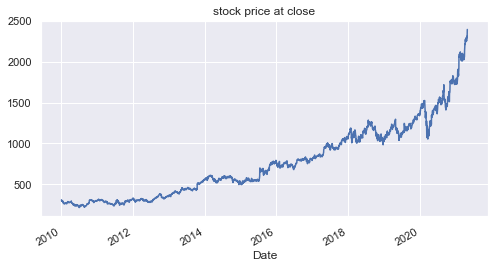

In [37]:
df['Close'].plot(title="stock price at close")

<AxesSubplot:title={'center':'daily return'}, xlabel='Date'>

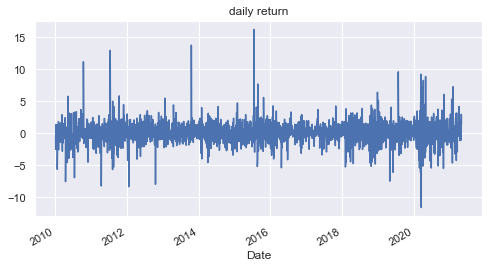

In [38]:
df['Return'].plot(title="daily return")

In [39]:
train,test = df[df.index<'2021-01-01'],df[df.index>='2021-01-01']

## Fit a Garch Model With Train

In [40]:
basic_gm = arch_model(df['Return'], p=1, o=0, q=1,
                      vol = 'GARCH', dist = 'normal')
res = basic_gm.fit(last_obs=test.index[0],disp='off') #np.where(df.index >= train.index[-1])[0].min()

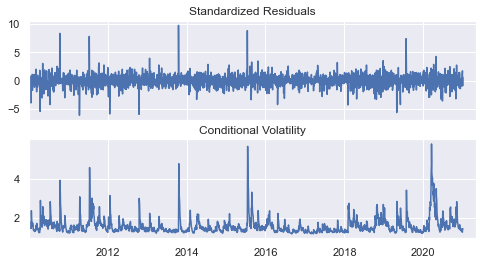

In [41]:
res.plot()
plt.show()

In [42]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5151.51
Distribution:                  Normal   AIC:                           10311.0
Method:            Maximum Likelihood   BIC:                           10334.7
                                        No. Observations:                 2768
Date:                Sat, Nov 20 2021   Df Residuals:                     2767
Time:                        04:45:37   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0779  3.009e-02      2.588  9.652e-03 [1.890e-02,  0.137]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.3028      0.171      1.768  7.702e-02 [-3.283e-02,  0.639]
alpha[1]       0.1106  5.794e-02      1.910  5.618e-02 [-2.914e-03,  0.224]
beta[1]        0.7811      0.101      7.731  1.064e-14    [  0.583,  0.979]
===========================================================================

Covariance estimator: robust
"""

## Fixed Window Forecast

In [43]:
# predictions_df = test.copy()
# # Predictions
# predictions_df["Predictions"] = res.forecast().residual_variance.loc[test.index]

# # PLOTTING FORECASTS
# # Setting the Figure Size
# plt.rcParams["figure.figsize"] = 10, 5

# # Plotting the Predictions and the test data
# plt.plot(predictions_df["Predictions"], label = "Predictions")
# plt.plot(predictions_df["Return"], label = "Actuals")

# # Setting the Title
# plt.title("Actuals vs Predictions for SPX Volatility", size = 20)

# # Displaying the labels and the plot respectively
# plt.legend()
# plt.show()

In [44]:
forecasts = res.forecast(horizon=1)
fixed = forecasts.variance.dropna()[1:]
print(fixed)

                 h.1
Date                
2021-01-04  2.168375
2021-01-05  2.055345
2021-01-06  2.033727
2021-01-07  2.827688
2021-01-08  2.683393
...              ...
2021-04-23  2.211152
2021-04-26  2.044127
2021-04-27  1.988831
2021-04-28  2.782300
2021-04-29  2.678266

[81 rows x 1 columns]


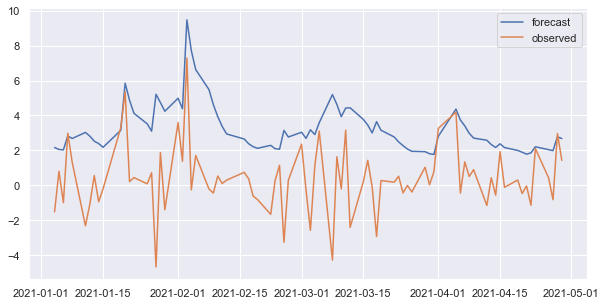

In [45]:
# Plot volatility forecast with a fixed rolling window
plt.figure(figsize=(10,5))
plt.plot(list(test.index), fixed.values.reshape(len(fixed)), label='forecast')
plt.plot(list(test.index), df.Return.loc[fixed.index], label='observed')
plt.legend()
plt.show()

## Rolling Window Forecast

In [46]:
index = df.index
start_loc = 0
end_loc = np.where(df.index >= train.index[-1])[0].min()
forecasts = {}
for i in range(len(test)):
    sys.stdout.write('.')
    sys.stdout.flush()
    res = basic_gm.fit(first_obs=i, last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print()
rolling = pd.DataFrame(forecasts).T
print(pd.DataFrame(forecasts).T)

.................................................................................
                 h.1
2020-12-30  2.105726
2020-12-31  2.029182
2021-01-04  2.169945
2021-01-05  2.057545
2021-01-06  2.034528
...              ...
2021-04-21  1.759631
2021-04-22  1.846727
2021-04-23  2.215646
2021-04-26  2.034128
2021-04-27  1.978480

[81 rows x 1 columns]


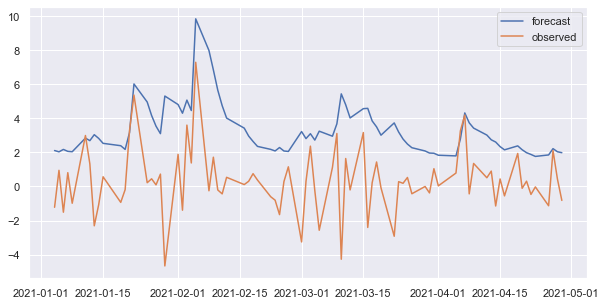

In [47]:
# Calculate volatility from variance forecast with a fixed rolling window
#vol_fixedwin = np.sqrt(fixed)

# Plot volatility forecast with a fixed rolling window
plt.figure(figsize=(10,5))
plt.plot(list(test.index), rolling.values.reshape(len(rolling)), label='forecast')
plt.plot(list(test.index), df.Return.loc[rolling.index], label='observed')
plt.legend()
plt.show()

In [50]:
#Get model estimated volatility
basic_vol = res.conditional_volatility

In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def evaluate(observation, forecast): 

    mae = mean_absolute_error(observation, forecast)
    print(f'Mean Absolute Error (MAE): {round(mae,3)}')

    mse = mean_squared_error(observation, forecast)
    print(f'Mean Squared Error (MSE): {round(mse,3)}')
    
    mape = mean_absolute_percentage_error(observation, forecast)
    print(f'Mean Absolute Percentage Error (MAPE): {round(mape,3)}')
    
    return mae, mse

evaluate(test.Return.values, rolling['h.1'])

Mean Absolute Error (MAE): 3.155
Mean Squared Error (MSE): 13.576
Mean Absolute Percentage Error (MAPE): 17.448


(3.155112137596928, 13.576226002917139)

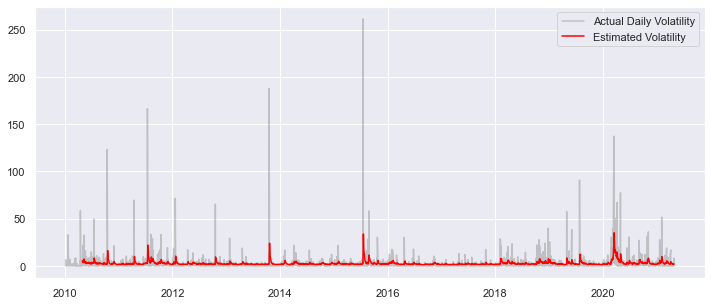

In [53]:
# Plot the actual Bitcoin volatility
plt.figure(figsize=(12,5))
plt.plot(df['Return'].sub(df['Return'].mean()).pow(2), 
         color = 'grey', alpha = 0.4, label = 'Actual Daily Volatility')

# Plot the estimated volatility
plt.plot(basic_vol**2, color = 'red', label = 'Estimated Volatility')

plt.legend(loc = 'upper right')
plt.show()